<a href="https://colab.research.google.com/github/MarciaFG/scimobility/blob/main/transformation_index_for_2007_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic transformation project (2007-2022)**
**Author:** Marcia R. Ferreira (Complexity Science Hub Vienna & TU Wien)
- **Inputs:** 

1.   CWTS SQL Server [dimensions_2022jun], up to date until 30-6-2022 08:27:51


      *   Exported File:
      *   Exported File:


2.   CWTS Publication-level classification system: Meso-fields level [dimensions_2022jun_classification]
3.   Dimension reduction-based clustering: Laplacian matrix contructed from meso-field level topic matrix and second eigenvector of the matrix
4.   Dimensions database on BigQuery, real time up to date


- **Outputs:**

### Initialization and drivers

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Tue Apr 18 12:42:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
#!pip install psutil
#!pip install humanize
#!pip install pynput
#pip install plotly==5.4.0
!pip install patool

# main libraries
import psutil
import humanize
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import requests
import torch
import nltk
import GPUtil as GPU
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

# plotting
import plotly.graph_objs as go
import plotly.io as pio
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Google big query
from google.cloud import bigquery
from google.colab import files
%load_ext google.colab.data_table
%load_ext google.cloud.bigquery

# mount drive
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Provide your credentials to the runtime
#from google.colab import auth
#auth.authenticate_user()
#print('Authenticated')

# declare your project 
#project_id = "cshdimensionstest"

### Data imports

In [ ]:
!ls "/content/drive/My Drive"

In [3]:
import patoolib
import tempfile
import os

# unzip the files exported from SQL Server
# Path of the zip file in Google Drive
zip_path = "/content/drive/My Drive/TRANSFORMATION/data_export.zip"

# Name of the CSV file(s) inside the zip
csv_file_names = [  "spectral_meso_clusters.csv"
                  , "for_division_labels.csv"
                  , "grid_ranks.csv"
                  , "trajectories_au_fourfive_skill.csv"
                  , "trajectories_au_morethanfive_skill.csv"
                  , "trajectories_au_single_skill.csv"
                  , "trajectories_au_twothree_skill.csv"]

# Separator character to use in the CSV files
separator = ";"

# Extract the zip file to a temporary directory
with tempfile.TemporaryDirectory() as tmpdir:
    patoolib.extract_archive(zip_path, outdir=tmpdir)
    
    # Load each CSV file into its own dataframe
    dfs = []
    for csv_file_name in csv_file_names:
        csv_file_path = os.path.join(tmpdir, csv_file_name)
        try:
            df = pd.read_csv(csv_file_path, sep=separator, encoding='utf-8', header= None, decimal=".")
            dfs.append(df)
        except pd.errors.ParserError:
            print(f"Error loading {csv_file_name}: Skipping...")

################################################################################

# Print the first few rows of each dataframe
for i, df in enumerate(dfs):
    print(f"Dataframe {i}:")
    print(df.head(2))
print("###########################################")

################################################################################

# extract the datasets and store them into a pandas dataframe
spectral_meso_clusters = dfs[0]
for_division_labels = dfs[1]
grid_ranks = dfs[2]
trajectories_au_fourfive_skill = dfs[3]
trajectories_au_morethanfive_skill = dfs[4]
trajectories_au_single_skill = dfs[5]
trajectories_au_twothree_skill = dfs[6]

################################################################################

print(type(for_division_labels))
print("###########################################")

patool: Extracting /content/drive/My Drive/TRANSFORMATION/data_export.zip ...
patool: running /usr/bin/7z x -o/tmp/tmpbi0syv27 -- "/content/drive/My Drive/TRANSFORMATION/data_export.zip"
patool: ... /content/drive/My Drive/TRANSFORMATION/data_export.zip extracted to `/tmp/tmpbi0syv27'.
Dataframe 0:
          0                   1                 2         3         4   \
0  row_index  second_eigenvector  original_indices  cluster2  cluster3   
1          0  -0,657980785697483               128         0         0   

         5         6          7            8       9   \
0  cluster4  cluster5  cluster10  cluster_id2  n_pubs   
1         0         0          0          128   99353   

                                                  10  \
0                                             labels   
1  inhaler - dry powder inhaler - inhaler devices...   

                                                  11  
0                                            sources  
1  International Journal o

## Preprocessing

In [4]:
# Use the first row as the header
spectral_meso_clusters.columns = spectral_meso_clusters.iloc[0]
#for_division_labels.columns = for_division_labels.iloc[0]
grid_ranks.columns = grid_ranks.iloc[0]

# Remove the first row (which is now the header)
spectral_meso_clusters = spectral_meso_clusters[1:]
#for_division_labels = for_division_labels[1:]
grid_ranks = grid_ranks[1:]

print(spectral_meso_clusters.head())
print(for_division_labels.head())
print(grid_ranks.head())
print("###########################################")

def convert_to_float(val):
    if isinstance(val, str) and val.replace('.', '', 1).isdigit():
        return float(val.replace(',', '.'))
    return val

# Apply the function to all elements of the dataframe
grid_ranks = grid_ranks.applymap(convert_to_float)
spectral_meso_clusters = spectral_meso_clusters.applymap(convert_to_float)

print(grid_ranks.dtypes)
print(spectral_meso_clusters.dtypes)
print("###########################################")


from pandas.core.dtypes.dtypes import dtypes
from numpy.core.multiarray import dtype

headers = ['researcher_id', 'grid_id', 'start', 'end', 'Lenght', 'for_division_id', 'meso_field', 'spectral_cluster_id', 'concatenated_fields', 'year', 'n_pubs']

# set the new column names using the list
trajectories_au_morethanfive_skill.columns = headers
trajectories_au_fourfive_skill.columns = headers
trajectories_au_single_skill.columns = headers
trajectories_au_twothree_skill.columns = headers

for_division_labels = for_division_labels.set_axis(for_division_labels.iloc[0], axis=1).iloc[1:].reset_index(drop=True)
for_division_labels


# print the updated column names
print(trajectories_au_morethanfive_skill.columns)
print(trajectories_au_morethanfive_skill.dtypes)
print("###########################################")

#print(trajectories_au_morethanfive_skill.describe())

0 row_index   second_eigenvector original_indices cluster2 cluster3 cluster4  \
1         0   -0,657980785697483              128        0        0        0   
2         9  -0,0796790037139393              109        4        3        2   
3         6  -0,0866583191228655              146        3        2        1   
4         7  -0,0835526247765448              120        3        2        1   
5         8  -0,0832388670665863              247        4        2        2   

0 cluster5 cluster10 cluster_id2  n_pubs  \
1        0         0         128   99353   
2        1         0         109  106502   
3        1         0         146   91599   
4        1         0         120  102555   
5        1         0         247   65569   

0                                             labels  \
1  inhaler - dry powder inhaler - inhaler devices...   
2  CRT response - CRT device - CRT implantation -...   
3  chiral selector - electrochromatography - plat...   
4  household air pollution - c

In [5]:
# lets select one for_division_id for now based on the distribution
dist_au_morethanfive_skill = trajectories_au_morethanfive_skill[['researcher_id', 'for_division_id']].drop_duplicates().reset_index(drop=True)
counts_morethanfive_skill = dist_au_morethanfive_skill.groupby('for_division_id').size()

dist_au_fourfive_skill = trajectories_au_fourfive_skill[['researcher_id', 'for_division_id']].drop_duplicates().reset_index(drop=True)
counts_fourfive_skill = dist_au_fourfive_skill.groupby('for_division_id').size()

dist_au_single_skill = trajectories_au_single_skill[['researcher_id', 'for_division_id']].drop_duplicates().reset_index(drop=True)
counts_single_skill = dist_au_single_skill.groupby('for_division_id').size()

dist_au_twothree_skill = trajectories_au_twothree_skill[['researcher_id', 'for_division_id']].drop_duplicates().reset_index(drop=True)
counts_twothree_skill = dist_au_twothree_skill.groupby('for_division_id').size()

In [6]:
dist_au_morethanfive_skill.sort_values(by = 'researcher_id')

,researcher_id,for_division_id
0,ur.01000000010.53,11
1,ur.01000000145.32,11
2,ur.01000000145.32,6
3,ur.01000000145.32,3
4,ur.01000000145.32,7
...,...,...
7037020,ur.07777775175.77,11
7037021,ur.0777777665.23,11
7037022,ur.0777777665.23,9
7037023,ur.0777777774.33,11


In [7]:
print(counts_morethanfive_skill.sort_values(ascending=False)) # 11
print("#######################################################")
print(counts_fourfive_skill.sort_values(ascending=False)) # 11
print("#######################################################")
print(counts_single_skill.sort_values(ascending=False)) # 9
print("#######################################################")
print(counts_twothree_skill.sort_values(ascending=False)) # 11
print("#######################################################")
print(for_division_labels.sort_values(by = 'for_division_id', ascending=True))

# let's focus on these fields for now
# 11  Medical and Health Sciences 
# 9 Engineering
# 3 Chemical Sciences
# 14 Economics

for_division_id
11    1324980
6      921424
9      788474
3      679351
8      443037
2      422497
10     415103
17     381265
1      319644
5      227942
7      218717
16     163051
4      150015
13     123619
14     121460
15     101627
12      72367
20      51688
21      35669
18      32379
22      28000
19      14716
dtype: int64
#######################################################
for_division_id
11    733497
9     458397
6     450952
3     341837
8     223051
2     202948
17    153643
10    153628
1     149136
5     115981
7     107983
4      88649
16     84704
14     57804
15     56841
13     54123
12     31978
20     26792
21     18864
18     14645
22     14013
19      6625
dtype: int64
#######################################################
for_division_id
9     427405
11    377123
6     261334
3     248461
2     215793
8     164735
1     143401
10     86397
4      81158
17     79467
7      61211
5      58160
16     38247
15     32571
14     29101
13     23939
20     19130

## FOR = 11 | Medical and Health Sciences

In [8]:
def calculate_org_sequence(df):
    # add a filter based on the value of for_division_id
    for_division_id_filter = (df['for_division_id'] == 11)

    # select the desired columns and drop duplicates
    df = df[['researcher_id', 'grid_id', 'for_division_id', 'spectral_cluster_id', 'start', 'end']][for_division_id_filter].drop_duplicates().reset_index(drop=True)
    
    # concatenate start, end, and for_division_id columns
    df['concatenated'] = df['start'].astype(str) + '_' + df['end'].astype(str)
    
    # calculate the org_sequence using rank() method that considers concatenated column
    df['org_sequence'] = df.groupby('researcher_id')['concatenated'].rank(method='dense')
    
    # drop the concatenated column
    df = df.drop('concatenated', axis=1)
    
    # return the researcher_id, grid_id, for_division_id, and org_sequence columns
    return df[['researcher_id', 'grid_id', 'for_division_id', 'spectral_cluster_id', 'org_sequence']]

################################################################################

def process_dataframe(df, org_seq_df):
    # merge the dataframes on researcher_id and grid_id
    merged_df = pd.merge(df, org_seq_df, on=['researcher_id', 'grid_id', 'for_division_id', 'spectral_cluster_id'], how='left')
    merged_df = merged_df.loc[:, ~merged_df.columns.str.endswith('_y')]
    merged_df = merged_df.rename(columns=lambda x: x[:-2] if x.endswith('_x') else x)

    # concatenate two columns
    merged_df['concatenated_2'] = merged_df['for_division_id'].astype(str) + ' - ' + merged_df['spectral_cluster_id'].astype(str)

    # select and aggregate columns
    selected_cols = ['researcher_id', 'grid_id', 'for_division_id', 'spectral_cluster_id', 'concatenated_2', 'org_sequence', 'n_pubs']
    selected_df = merged_df[selected_cols].drop_duplicates().reset_index(drop=True)
    aggregated_df = selected_df.groupby(['researcher_id', 'grid_id', 'for_division_id', 'spectral_cluster_id', 'concatenated_2','org_sequence']).sum().reset_index()

    return aggregated_df

################################################################################

sq_1_skill_df = process_dataframe(trajectories_au_single_skill, calculate_org_sequence(trajectories_au_single_skill))
sq_2_3_skill_df = process_dataframe(trajectories_au_twothree_skill, calculate_org_sequence(trajectories_au_twothree_skill))
sq_4_5_skill_df = process_dataframe(trajectories_au_fourfive_skill, calculate_org_sequence(trajectories_au_fourfive_skill))
sq_5_or_more_skill_df = process_dataframe(trajectories_au_morethanfive_skill, calculate_org_sequence(trajectories_au_morethanfive_skill))

################################################################################

print(sq_1_skill_df.head())
print(len(sq_1_skill_df))
print(len(trajectories_au_single_skill))

        researcher_id        grid_id  for_division_id  spectral_cluster_id  \
0  ur.010000007232.43    grid.5596.f               11                   81   
1   ur.01000001217.11  grid.32224.35               11                   77   
2   ur.01000001415.60  grid.427788.6               11                   25   
3  ur.010000022373.01  grid.411154.4               11                   76   
4   ur.01000002646.33    grid.9668.1               11                    0   

  concatenated_2  org_sequence  n_pubs  
0        11 - 81           1.0      10  
1        11 - 77           1.0       1  
2        11 - 25           1.0       1  
3        11 - 76           1.0       1  
4         11 - 0           1.0       1  
415699
5522947


In [9]:
# lets simplify the datasets first
six_plus = sq_5_or_more_skill_df[['researcher_id', 'spectral_cluster_id', 'n_pubs', 'org_sequence']].reset_index(drop=True)
four_five = sq_4_5_skill_df[['researcher_id', 'spectral_cluster_id', 'n_pubs', 'org_sequence']].reset_index(drop=True)
two_three = sq_2_3_skill_df[['researcher_id', 'spectral_cluster_id', 'n_pubs', 'org_sequence']].reset_index(drop=True)
single = sq_1_skill_df[['researcher_id', 'spectral_cluster_id', 'n_pubs', 'org_sequence']].reset_index(drop=True) # not used for now
#five_plus.head(100)
# the data is ordered too
#df_test = four_five
#print(df_test.head(20))
#four_five[(four_five["researcher_id"] == 'ur.01000022633.41')]
#four_five[(four_five["org_sequence"] == 3)]

## The fun starts here!

In [9]:
#@title preprocess function - not used
def process_dataframe(df):
    topicIds = df.spectral_cluster_id.unique()
    topicIds.sort()
    auIds = df.researcher_id.unique()
    auIds.sort()

    m = auIds.size
    n = topicIds.size
    #numPubs = len(df)

    print("There are", m, "researchers, and", n, "topics")

    topicId_to_topicIDX = dict(zip(topicIds, range(0, topicIds.size)))
    topicIDX_to_topicId = dict(zip(range(0, topicIds.size), topicIds))

    auId_to_auIDX = dict(zip(auIds, range(0, auIds.size)))
    auIDX_to_auId = dict(zip(range(0, auIds.size), auIds))

    pubs = pd.concat([df['researcher_id'].map(auId_to_auIDX), df['spectral_cluster_id'].map(topicId_to_topicIDX), df['n_pubs'], df['org_sequence']], axis=1)

    pubs.columns = ['au', 'topic', 'pubs', 'time']

    pubs = pubs.sort_values(by=['au', 'time', 'topic'])

    print(pubs.head(10))
    #print(type(pubs))

    return pubs

**Make sure that clusters and researchers have consecutive indexes starting from 0.**

Note that the dataframe containing authors with only 1 skill with constantly have a cosine score of 1 each time, hence we exclude these from the analysis as we are interested in the profile changes (at least for now)

### Two to three skills

In [10]:
##########################
### TWO THREE SKILLS #####
##########################
topicIds_0 = two_three.spectral_cluster_id.unique()
topicIds_0.sort()
auIds_0 = two_three.researcher_id.unique()
auIds_0.sort()

m = auIds_0.size
n = topicIds_0.size
#numPubs = len(df)

print("There are", m, "researchers, and", n, "topics")

topicId_to_topicIDX_0 = dict(zip(topicIds_0, range(0, topicIds_0.size)))
topicIDX_to_topicId_0 = dict(zip(range(0, topicIds_0.size), topicIds_0))

auId_to_auIDX_0 = dict(zip(auIds_0, range(0, auIds_0.size)))
auIDX_to_auId_0 = dict(zip(range(0, auIds_0.size), auIds_0))

au_two_three = pd.concat([two_three['researcher_id'].map(auId_to_auIDX_0), two_three['spectral_cluster_id'].map(topicId_to_topicIDX_0), two_three['n_pubs'], two_three['org_sequence']], axis=1)

au_two_three.columns = ['au', 'topic', 'pubs', 'time']

au_two_three = au_two_three.sort_values(by=['au', 'time', 'topic'])

print(au_two_three.sort_values(by =['au', 'topic', 'time']).head(10))

#au_two_three = process_dataframe(two_three)

#@title Cosine calculation
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Create a dictionary to store the researcher's topic vectors for each time period
researcher_time_vectors_two_three = defaultdict(lambda: defaultdict(lambda: np.zeros(n)))

for idx, row in au_two_three.iterrows():
    au_idx, topic_idx, pub_count, time = row
    researcher_time_vectors_two_three[au_idx][int(time)][int(topic_idx)] = pub_count

# Step 2: Calculate the cosine similarity between consecutive time periods for each researcher
cosine_similarities = {}

for researcher, time_vectors in researcher_time_vectors_two_three.items():
    cosine_similarities[researcher] = []
    time_keys = sorted(time_vectors.keys())
    for i in range(1, len(time_keys)):
        time1 = time_keys[i - 1]
        time2 = time_keys[i]
        vec1 = time_vectors[time1].reshape(1, -1)
        vec2 = time_vectors[time2].reshape(1, -1)
        similarity = cosine_similarity(vec1, vec2)
        cosine_similarities[researcher].append((time1, time2, similarity[0][0]))

# Step 3: Display the cosine similarity values
# for researcher, similarities in cosine_similarities.items():
#    print(f"Researcher {researcher}:")
#    for time1, time2, sim in similarities:
#        print(f"  Cosine Similarity between time {time1} and {time2}: {sim:.4f}")

# Identify non-mobile researchers
non_mobile_two_three = [user for user, times in researcher_time_vectors_two_three.items() if len(times) == 1]

# Display the users with only one-time step
#print("Users with only one-time step:")
#for user in single_time_users:
#   print(f"  Researcher {user}")

# Convert the cosine similarities dictionary to a list of dictionaries
similarity_data = []

for researcher, similarities in cosine_similarities.items():
    for time1, time2, sim in similarities:
        similarity_data.append({
            'researcher_idx': researcher,
            'researcher_id': auIDX_to_auId_0[researcher],  # Add the real researcher_id
            'time1': time1,
            'time2': time2,
            'cosine_similarity': sim
        })

# Create a DataFrame from the list of dictionaries
similarity_df_two_three = pd.DataFrame(similarity_data)

print('Similarity of researcher with two or three skills')
print(similarity_df_two_three.head(20))
print('#################################################')

There are 1283735 researchers, and 87 topics
   au  topic  pubs  time
0   0     14     1   1.0
1   0     68     1   1.0
2   0     78     2   1.0
3   1     83     1   1.0
4   2      5     1   1.0
5   2     75     1   1.0
6   3     76     2   1.0
7   3     83     3   1.0
8   4      1     2   1.0
9   4     55     1   1.0
Similarity of researcher with two or three skills
    researcher_idx       researcher_id  time1  time2  cosine_similarity
0              4.0   ur.01000000273.38      1      2           0.912871
1              6.0   ur.01000000410.68      1      2           0.986394
2              6.0   ur.01000000410.68      2      3           1.000000
3             16.0  ur.010000014661.30      1      2           0.707107
4             18.0   ur.01000001604.30      1      2           0.707107
5             24.0   ur.01000002626.88      1      2           1.000000
6             25.0   ur.01000003111.36      1      2           1.000000
7             25.0   ur.01000003111.36      2      3  

In [19]:
# check results:
print(au_two_three.sort_values(by =['au', 'topic', 'time']).head(10))
print(two_three[(two_three["researcher_id"] == 'ur.01000000273.38')])
print(similarity_df_two_three[(similarity_df_two_three["researcher_id"] == 'ur.01000000273.38')])

    au  topic  pubs  time
0    0     14     1   1.0
1    0     68     1   1.0
2    0     78     2   1.0
3    1     83     1   1.0
4    2      5     1   1.0
5    2     75     1   1.0
6    3     76     2   1.0
7    3     83     3   1.0
8    4      1     2   1.0
10   4      1     2   2.0
        researcher_id  spectral_cluster_id  n_pubs  org_sequence
8   ur.01000000273.38                    1       2           1.0
9   ur.01000000273.38                   55       1           1.0
10  ur.01000000273.38                    1       2           2.0
11  ur.01000000273.38                   55       1           2.0
12  ur.01000000273.38                   83       1           2.0
   researcher_idx      researcher_id  time1  time2  cosine_similarity
0             4.0  ur.01000000273.38      1      2           0.912871


### Four to five skills

In [11]:
#@title Cosine calculation
##########################
### FOUR FIVE SKILLS #####
##########################

topicIds_1 = four_five.spectral_cluster_id.unique()
topicIds_1.sort()
auIds_1 = four_five.researcher_id.unique()
auIds_1.sort()

m = auIds_1.size
n = topicIds_1.size
#numPubs = len(df)

print("There are", m, "researchers, and", n, "topics")

topicId_to_topicIDX_1 = dict(zip(topicIds_1, range(0, topicIds_1.size)))
topicIDX_to_topicId_1 = dict(zip(range(0, topicIds_1.size), topicIds_1))

auId_to_auIDX_1 = dict(zip(auIds_1, range(0, auIds_1.size)))
auIDX_to_auId_1 = dict(zip(range(0, auIds_1.size), auIds_1))

au_four_five = pd.concat([four_five['researcher_id'].map(auId_to_auIDX_1), four_five['spectral_cluster_id'].map(topicId_to_topicIDX_1), four_five['n_pubs'], four_five['org_sequence']], axis=1)

au_four_five.columns = ['au', 'topic', 'pubs', 'time']

au_four_five = au_four_five.sort_values(by=['au', 'time', 'topic'])

print(au_four_five.head(10))

#au_four_five = process_dataframe(four_five)

# Step 1: Create a dictionary to store the researcher's topic vectors for each time period
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

researcher_time_vectors_four_five = defaultdict(lambda: defaultdict(lambda: np.zeros(n)))

for idx, row in au_four_five.iterrows():
    au_idx, topic_idx, pub_count, time = row
    researcher_time_vectors_four_five[au_idx][int(time)][int(topic_idx)] = pub_count

# Step 2: Calculate the cosine similarity between consecutive time periods for each researcher
cosine_similarities = {}

for researcher, time_vectors in researcher_time_vectors_four_five.items():
    cosine_similarities[researcher] = []
    time_keys = sorted(time_vectors.keys())
    for i in range(1, len(time_keys)):
        time1 = time_keys[i - 1]
        time2 = time_keys[i]
        vec1 = time_vectors[time1].reshape(1, -1)
        vec2 = time_vectors[time2].reshape(1, -1)
        similarity = cosine_similarity(vec1, vec2)
        cosine_similarities[researcher].append((time1, time2, similarity[0][0]))

# Identify non-mobile researchers
non_mobile_four_five = [user for user, times in researcher_time_vectors_four_five.items() if len(times) == 1]

# Convert the cosine similarities dictionary to a list of dictionaries
similarity_data = []

for researcher, similarities in cosine_similarities.items():
    for time1, time2, sim in similarities:
        similarity_data.append({
            'researcher_idx': researcher,
            'researcher_id': auIDX_to_auId_1[researcher],  # Add the real researcher_id
            'time1': time1,
            'time2': time2,
            'cosine_similarity': sim
        })

# Create a DataFrame from the list of dictionaries
similarity_df_four_five = pd.DataFrame(similarity_data)

print('Similarity of researcher with four or five skills')
print(similarity_df_four_five.head(20))
print('#################################################')

There are 733497 researchers, and 87 topics
    au  topic  pubs  time
0    0     17     1   1.0
1    0     63     4   1.0
2    0     68     2   1.0
3    0     71    16   1.0
5    1      7     1   1.0
6    1     81     1   1.0
4    1     81     1   2.0
7    2     73     1   1.0
8    2     79     1   1.0
10   3     22     1   1.0
Similarity of researcher with four or five skills
    researcher_idx       researcher_id  time1  time2  cosine_similarity
0              1.0   ur.01000000322.68      1      2           0.707107
1              3.0   ur.01000000511.88      1      2           0.000000
2              5.0   ur.01000001435.12      1      2           0.707107
3             17.0   ur.01000004775.38      1      2           0.707107
4             18.0   ur.01000004776.35      1      2           0.905822
5             22.0   ur.01000005627.44      1      2           0.784465
6             26.0   ur.01000006303.77      1      2           0.000000
7             30.0   ur.01000010265.50      

### More than six skills

In [12]:
#@title Cosine calculation
##########################
### SIX OR MORE SKILLS ###
##########################

topicIds_2 = six_plus.spectral_cluster_id.unique()
topicIds_2.sort()
auIds_2 = six_plus.researcher_id.unique()
auIds_2.sort()

m = auIds_2.size
n = topicIds_2.size
#numPubs = len(df)

print("There are", m, "researchers, and", n, "topics")

topicId_to_topicIDX_2 = dict(zip(topicIds_2, range(0, topicIds_2.size)))
topicIDX_to_topicId_2 = dict(zip(range(0, topicIds_2.size), topicIds_2))

auId_to_auIDX_2 = dict(zip(auIds_2, range(0, auIds_2.size)))
auIDX_to_auId_2 = dict(zip(range(0, auIds_2.size), auIds_2))

au_six_plus = pd.concat([six_plus['researcher_id'].map(auId_to_auIDX_2), six_plus['spectral_cluster_id'].map(topicId_to_topicIDX_2), six_plus['n_pubs'], six_plus['org_sequence']], axis=1)

au_six_plus.columns = ['au', 'topic', 'pubs', 'time']

au_six_plus = au_six_plus.sort_values(by=['au', 'time', 'topic'])

print(au_six_plus.head(10))

#au_six_plus = process_dataframe(six_plus)

# Step 1: Create a dictionary to store the researcher's topic vectors for each time period
researcher_time_vectors_six_plus = defaultdict(lambda: defaultdict(lambda: np.zeros(n)))

for idx, row in au_six_plus.iterrows():
    au_idx, topic_idx, pub_count, time = row
    researcher_time_vectors_six_plus[au_idx][int(time)][int(topic_idx)] = pub_count

# Step 2: Calculate the cosine similarity between consecutive time periods for each researcher
cosine_similarities = {}

for researcher, time_vectors in researcher_time_vectors_six_plus.items():
    cosine_similarities[researcher] = []
    time_keys = sorted(time_vectors.keys())
    for i in range(1, len(time_keys)):
        time1 = time_keys[i - 1]
        time2 = time_keys[i]
        vec1 = time_vectors[time1].reshape(1, -1)
        vec2 = time_vectors[time2].reshape(1, -1)
        similarity = cosine_similarity(vec1, vec2)
        cosine_similarities[researcher].append((time1, time2, similarity[0][0]))

# Identify non-mobile researchers
non_mobile_six_plus = [user for user, times in researcher_time_vectors_six_plus.items() if len(times) == 1]

# Convert the cosine similarities dictionary to a list of dictionaries
similarity_data = []

for researcher, similarities in cosine_similarities.items():
    if researcher not in auIDX_to_auId_2:
        print(f"Researcher index not found in auIDX_to_auId: {researcher}")

    for time1, time2, sim in similarities:
        similarity_data.append({
            'researcher_idx': researcher,
            'researcher_id': auIDX_to_auId_2.get(researcher, 'Unknown'),  # Add the real researcher_id
            'time1': time1,
            'time2': time2,
            'cosine_similarity': sim
        })

# Create a DataFrame from the list of dictionaries
similarity_df_six_plus= pd.DataFrame(similarity_data)

print('Similarity of researcher with six or more skills')
print(similarity_df_six_plus.head(20))
print('Calculation end')

There are 1324980 researchers, and 87 topics
   au  topic  pubs  time
0   0      5     1   1.0
1   0      6     1   1.0
2   0      8     4   1.0
3   0     29     1   1.0
4   0     64    21   1.0
5   0     76     6   1.0
6   0     82     1   1.0
7   0     84     1   1.0
8   0      5     1   2.0
9   0      6     1   2.0
Similarity of researcher with six or more skills
    researcher_idx       researcher_id  time1  time2  cosine_similarity
0              0.0   ur.01000000010.53      1      2           0.201650
1              1.0   ur.01000000145.32      1      2           0.139686
2              1.0   ur.01000000145.32      2      3           0.000000
3              1.0   ur.01000000145.32      3      4           0.377964
4              1.0   ur.01000000145.32      4      5           0.327327
5              1.0   ur.01000000145.32      5      6           0.335968
6              1.0   ur.01000000145.32      6      7           0.000000
7              1.0   ur.01000000145.32      7      8   

# Visualizations

    num_changes  average_similarity  num_researchers
0             2            0.756631           102068
1             3            0.818835            12027
2             4            0.851067             1973
3             5            0.879968              413
4             6            0.878042               98
5             7            0.912069               39
6             8            0.804071               11
7             9            0.913948                4
8            10            0.890273                3
9            11            0.792642                3
10           12            0.948683                1
11           13            0.904534                1
12           14            0.852803                1
13           15            1.000000                1
14           16            0.707107                1


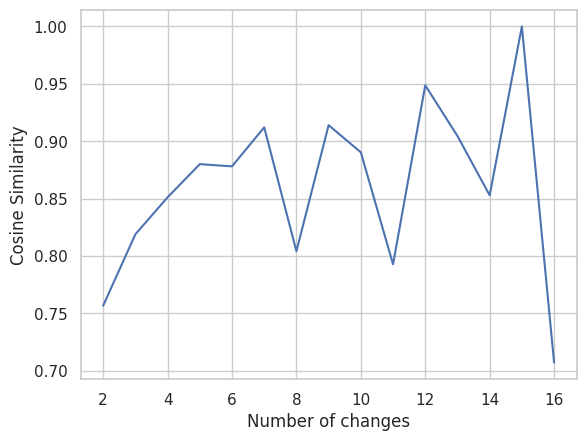

<Figure size 1000x600 with 0 Axes>

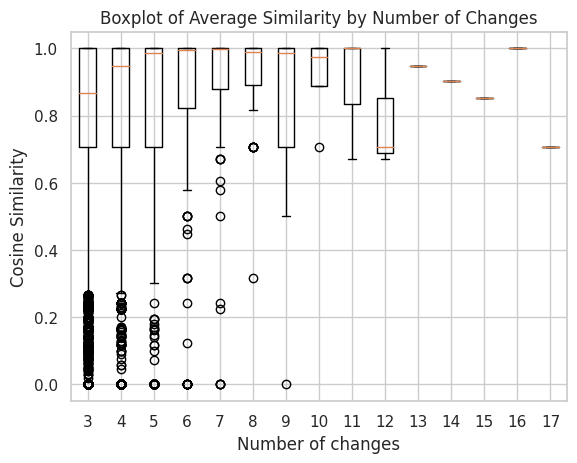

In [129]:
# group by 'num_changes' and calculate the mean of 'average_similarity' column
summary_stats_change = similarity_df.groupby('time2')['cosine_similarity'].agg(['mean', 'count']).reset_index()
summary_stats_change.columns = ['num_changes', 'average_similarity', 'num_researchers']

fig, ax = plt.subplots()
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

ax.plot(summary_stats_change['num_changes'], summary_stats_change['average_similarity'])
ax.set_xlabel('Number of changes')
ax.set_ylabel('Cosine Similarity')
# ax.legend(loc='best')

print(summary_stats_change.head(15))

# create the boxplot
# create the boxplot
fig, ax = plt.subplots()
data_to_plot = [similarity_df[similarity_df['time2'] == x]['cosine_similarity'].tolist() for x in summary_stats_change['num_changes']]
ax.boxplot(data_to_plot)
ax.set_xticklabels(summary_stats_change['num_changes'].values + 1)
ax.set_xlabel('Number of changes')
ax.set_ylabel('Cosine Similarity')
ax.set_title('Boxplot of Average Similarity by Number of Changes')

plt.show()

             researcher_id  average_similarity  num_changes
0        ur.01000000273.38            0.912871            1
1        ur.01000000410.68            0.993197            2
2       ur.010000014661.30            0.707107            1
3        ur.01000001604.30            0.707107            1
4        ur.01000002626.88            1.000000            1
...                    ...                 ...          ...
102063    ur.0777770636.48            0.894427            1
102064    ur.0777773733.54            0.707107            1
102065    ur.0777776657.26            0.894427            1
102066    ur.0777777114.54            1.000000            2
102067    ur.0777777367.75            0.904534            1

[102068 rows x 3 columns]
###################################################################
            researcher_id  average_similarity  num_changes
0       ur.01000000273.38            0.912871            1
66005  ur.014404246515.31            0.500000            1
66004  u

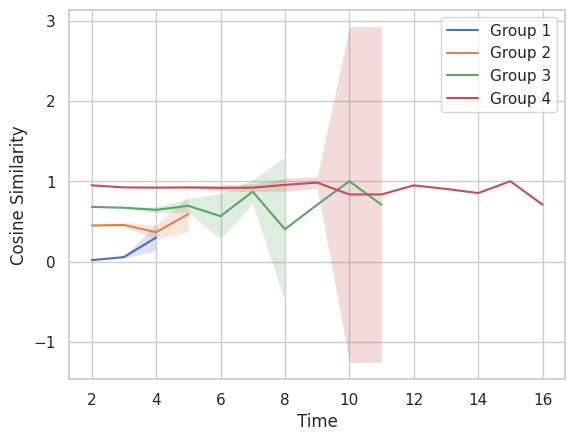

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 1. Define a function to categorize researchers based on their average_similarity
def categorize_researcher(avg_similarity, num_groups=4):
    if avg_similarity <= 0.25:
        return 1
    elif avg_similarity <= 0.5:
        return 2
    elif avg_similarity <= 0.75:
        return 3
    else:
        return 4

# Calculate the average cosine similarity change and the number of changes for each researcher
researcher_means = similarity_df.groupby('researcher_id')['cosine_similarity'].agg(['mean', 'count']).reset_index()
researcher_means.columns = ['researcher_id', 'average_similarity', 'num_changes']

# Display the summary statistics
print(researcher_means)

print('###################################################################')

print(researcher_means.sort_values(by='num_changes'))

# 2. Apply the function to the summary_stats DataFrame to create a new column `group`
researcher_means['group'] = researcher_means['average_similarity'].apply(categorize_researcher)

# 3. Merge the `group` information into the `similarity_df` DataFrame
similarity_df = pd.merge(similarity_df, researcher_means[['researcher_id', 'group']], on='researcher_id')

# 4. Aggregate cosine similarity values for each group and time period
grouped_data = similarity_df.groupby(['group', 'time2'])['cosine_similarity'].agg(['mean', 'std', 'count']).reset_index()

# 5. Calculate the confidence intervals
alpha = 0.95
grouped_data['conf_interval'] = grouped_data.apply(lambda row: stats.t.ppf((1 + alpha) / 2, row['count'] - 1) * row['std'] / np.sqrt(row['count']), axis=1)

# 6. Create a line plot with confidence intervals around the lines for each group over time
fig, ax = plt.subplots()

for group_id, group_data in grouped_data.groupby('group'):
    ax.plot(group_data['time2'], group_data['mean'], label=f'Group {group_id}')
    ax.fill_between(group_data['time2'], group_data['mean'] - group_data['conf_interval'], group_data['mean'] + group_data['conf_interval'], alpha=0.2)

ax.set_xlabel('Time')
ax.set_ylabel('Cosine Similarity')
ax.legend(loc='best')

plt.show()


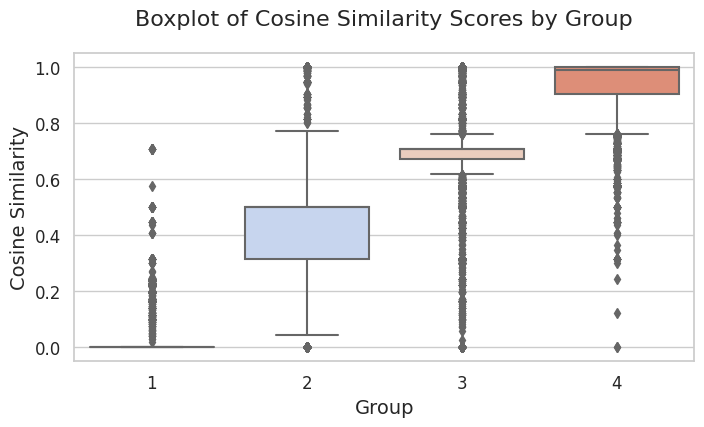

In [131]:
# boxplot by group
# Assuming your DataFrame is named 'df'
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
ax = sns.boxplot(x='group', y='cosine_similarity', data=similarity_df, palette='coolwarm')
ax.set_title('Boxplot of Cosine Similarity Scores by Group', fontsize=16, pad=20)
ax.set_xlabel('Group', fontsize=14)
ax.set_ylabel('Cosine Similarity', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

# Display the boxplot
plt.show()

In [132]:
similarity_df.head(10).sort_values(by='researcher_id')

,researcher_idx,researcher_id,time1,time2,cosine_similarity,group
0,4.0,ur.01000000273.38,1,2,0.912871,4
1,6.0,ur.01000000410.68,1,2,0.986394,4
2,6.0,ur.01000000410.68,2,3,1.000000,4
3,16.0,ur.010000014661.30,1,2,0.707107,3
4,18.0,ur.01000001604.30,1,2,0.707107,3
5,24.0,ur.01000002626.88,1,2,1.000000,4
6,25.0,ur.01000003111.36,1,2,1.000000,4
7,25.0,ur.01000003111.36,2,3,1.000000,4
8,49.0,ur.01000006736.20,1,2,1.000000,4
9,53.0,ur.01000007424.77,1,2,0.577350,3


**It looks like lower similarity groups are associated with less affiliation changes**
- make the same vizualization but for number of changes and see if they agree
- check academic age effects
- check for prestige effects
- make ranking of institutions by the four fields based on the cosine
- check how scholars change their profile over time regardless of changing behaviour


In [ ]:
#@title Default title text
from scipy.sparse import csr_matrix, dok_matrix

# Get unique researcher and topic counts
num_researchers = len(np.unique(pubs['au']))
num_topics = len(np.unique(pubs['topic']))

# Initialize the matrices
R = csr_matrix((num_researchers, num_topics), dtype=np.float64)
R_dok = dok_matrix((num_researchers, num_topics), dtype=np.float64)

# Fill the matrices with data from the 'pubs' DataFrame
for idx, row in pubs.iterrows():
    au_idx, topic_idx, pub_count, _ = row
    R[au_idx, topic_idx] = pub_count
    R_dok[au_idx, topic_idx] = pub_count

# Display the matrices
print("R matrix (csr_matrix):")
print(R)

print("\nR_dok matrix (dok_matrix):")
print(R_dok)